In [1]:
import numpy as np
import os
import torch
from torch import optim
import json
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

from data import set_up_data
from hps import *
from train import *
from vae import vae_encoder_wrapper, vae_decoder_wrapper

from matplotlib import pyplot as plt
from time import time

from utils_extra import *

%load_ext autoreload
%autoreload 2

# For LaTeX in matplotlib figures
plt.rcParams.update({
    "figure.facecolor":  (1,1,1,1), # White background, alpha = 100%
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [2]:
device_id = 0
device = 'cuda:%d' % device_id
torch.cuda.set_device(device_id)

print(torch.cuda.get_device_name(device_id))
print(torch.cuda.current_device())

NVIDIA GeForce RTX 2080 Ti
0


In [3]:
# Opening JSON file

with open('pretrained_models/ffhq256/H_params.json') as json_file:
    H_params = json.load(json_file)
        
H = Hyperparams()
H.update(H_params)

# FFHQ-256:
H.dataset = 'ffhq_256'

print('Model parameters:')
for k in H.keys():
    print(k,' : ', H[k])

Model parameters:
hparam_sets  :  ffhq256
restore_path  :  pretrained_models/ffhq256/ffhq256-iter-1700000-model.th
restore_ema_path  :  pretrained_models/ffhq256/ffhq256-iter-1700000-model-ema.th
restore_log_path  :  pretrained_models/ffhq256/ffhq256-iter-1700000-log.jsonl
restore_optimizer_path  :  pretrained_models/ffhq256/ffhq256-iter-1700000-opt.th
seed  :  0
port  :  29500
save_dir  :  ./saved_models
data_root  :  ./
desc  :  test
dataset  :  ffhq_256
ema_rate  :  0.999
enc_blocks  :  256x3,256d2,128x8,128d2,64x12,64d2,32x17,32d2,16x7,16d2,8x5,8d2,4x5,4d4,1x4
dec_blocks  :  1x2,4m1,4x3,8m4,8x4,16m8,16x9,32m16,32x21,64m32,64x13,128m64,128x7,256m128
zdim  :  16
width  :  512
custom_width_str  :  
bottleneck_multiple  :  0.25
no_bias_above  :  64
scale_encblock  :  False
test_eval  :  False
warmup_iters  :  100
num_mixtures  :  10
grad_clip  :  130.0
skip_threshold  :  180.0
lr  :  0.00015
lr_prior  :  0.00015
wd  :  0.01
wd_prior  :  0.0
num_epochs  :  10000
n_batch  :  1
adam_beta1

In [4]:
print('Loading data...')
tic = time()
H, data_train, data_valid_or_test, preprocess_fn = set_up_data(H)
toc = time()

print('Elapsed time: %.2f sec' % (toc-tic))

Loading data...
Elapsed time: 1.92 sec


/home/mario/Documentos/pytorch/jpmap_vdvae/data.py:78: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1631630836880/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  train_data = TensorDataset(torch.as_tensor(trX))


In [5]:
print('Loading VAE model...')
tic = time()
vae, ema_vae = load_vaes(H, None)
vae.requires_grad_(False)
toc = time()

print('Elapsed time: %.2f sec' % (toc-tic))

Loading VAE model...
Elapsed time: 2.64 sec


In [6]:
# FFHQ: Load dataset batch
n_batch = 10  # Size of the batch
dataloader = DataLoader(data_valid_or_test, batch_size=n_batch, drop_last=True, pin_memory=True)

batch = next(iter(dataloader))[0]
print(batch.shape)

torch.Size([10, 256, 256, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


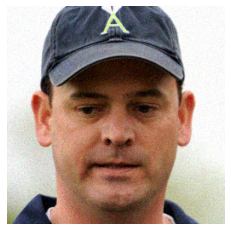

In [7]:
# Load image
ind = 9
image = batch[ind].float() / 255.

# Add Gaussian noise
noise_std = 10. / 255.
if noise_std:
    image += noise_std * torch.randn_like(image, dtype=image.dtype)

plt.imshow(image); plt.axis('off');

## Reconstrucción de cara del dataset

In [8]:
## Wrappers for VAE
endblock = 66
encoder = vae_encoder_wrapper(vae, preprocess_fn, endblock)
decoder = vae_decoder_wrapper(vae, preprocess_fn, endblock)

In [9]:
epsilon = vect2tensors(encoder(image)[None,:], endblock)
t = 1.

z_len = len(epsilon)
x_images = [vae.forward_samples_set_epsilon(1, epsilon, t)[0]]

null = [65, 57, 43, 21, 11, 6, 2]

for j in null:
    for i in range(j,z_len):
        epsilon[i] *= 0

    x_images.append(vae.forward_samples_set_epsilon(1, epsilon, t)[0].cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


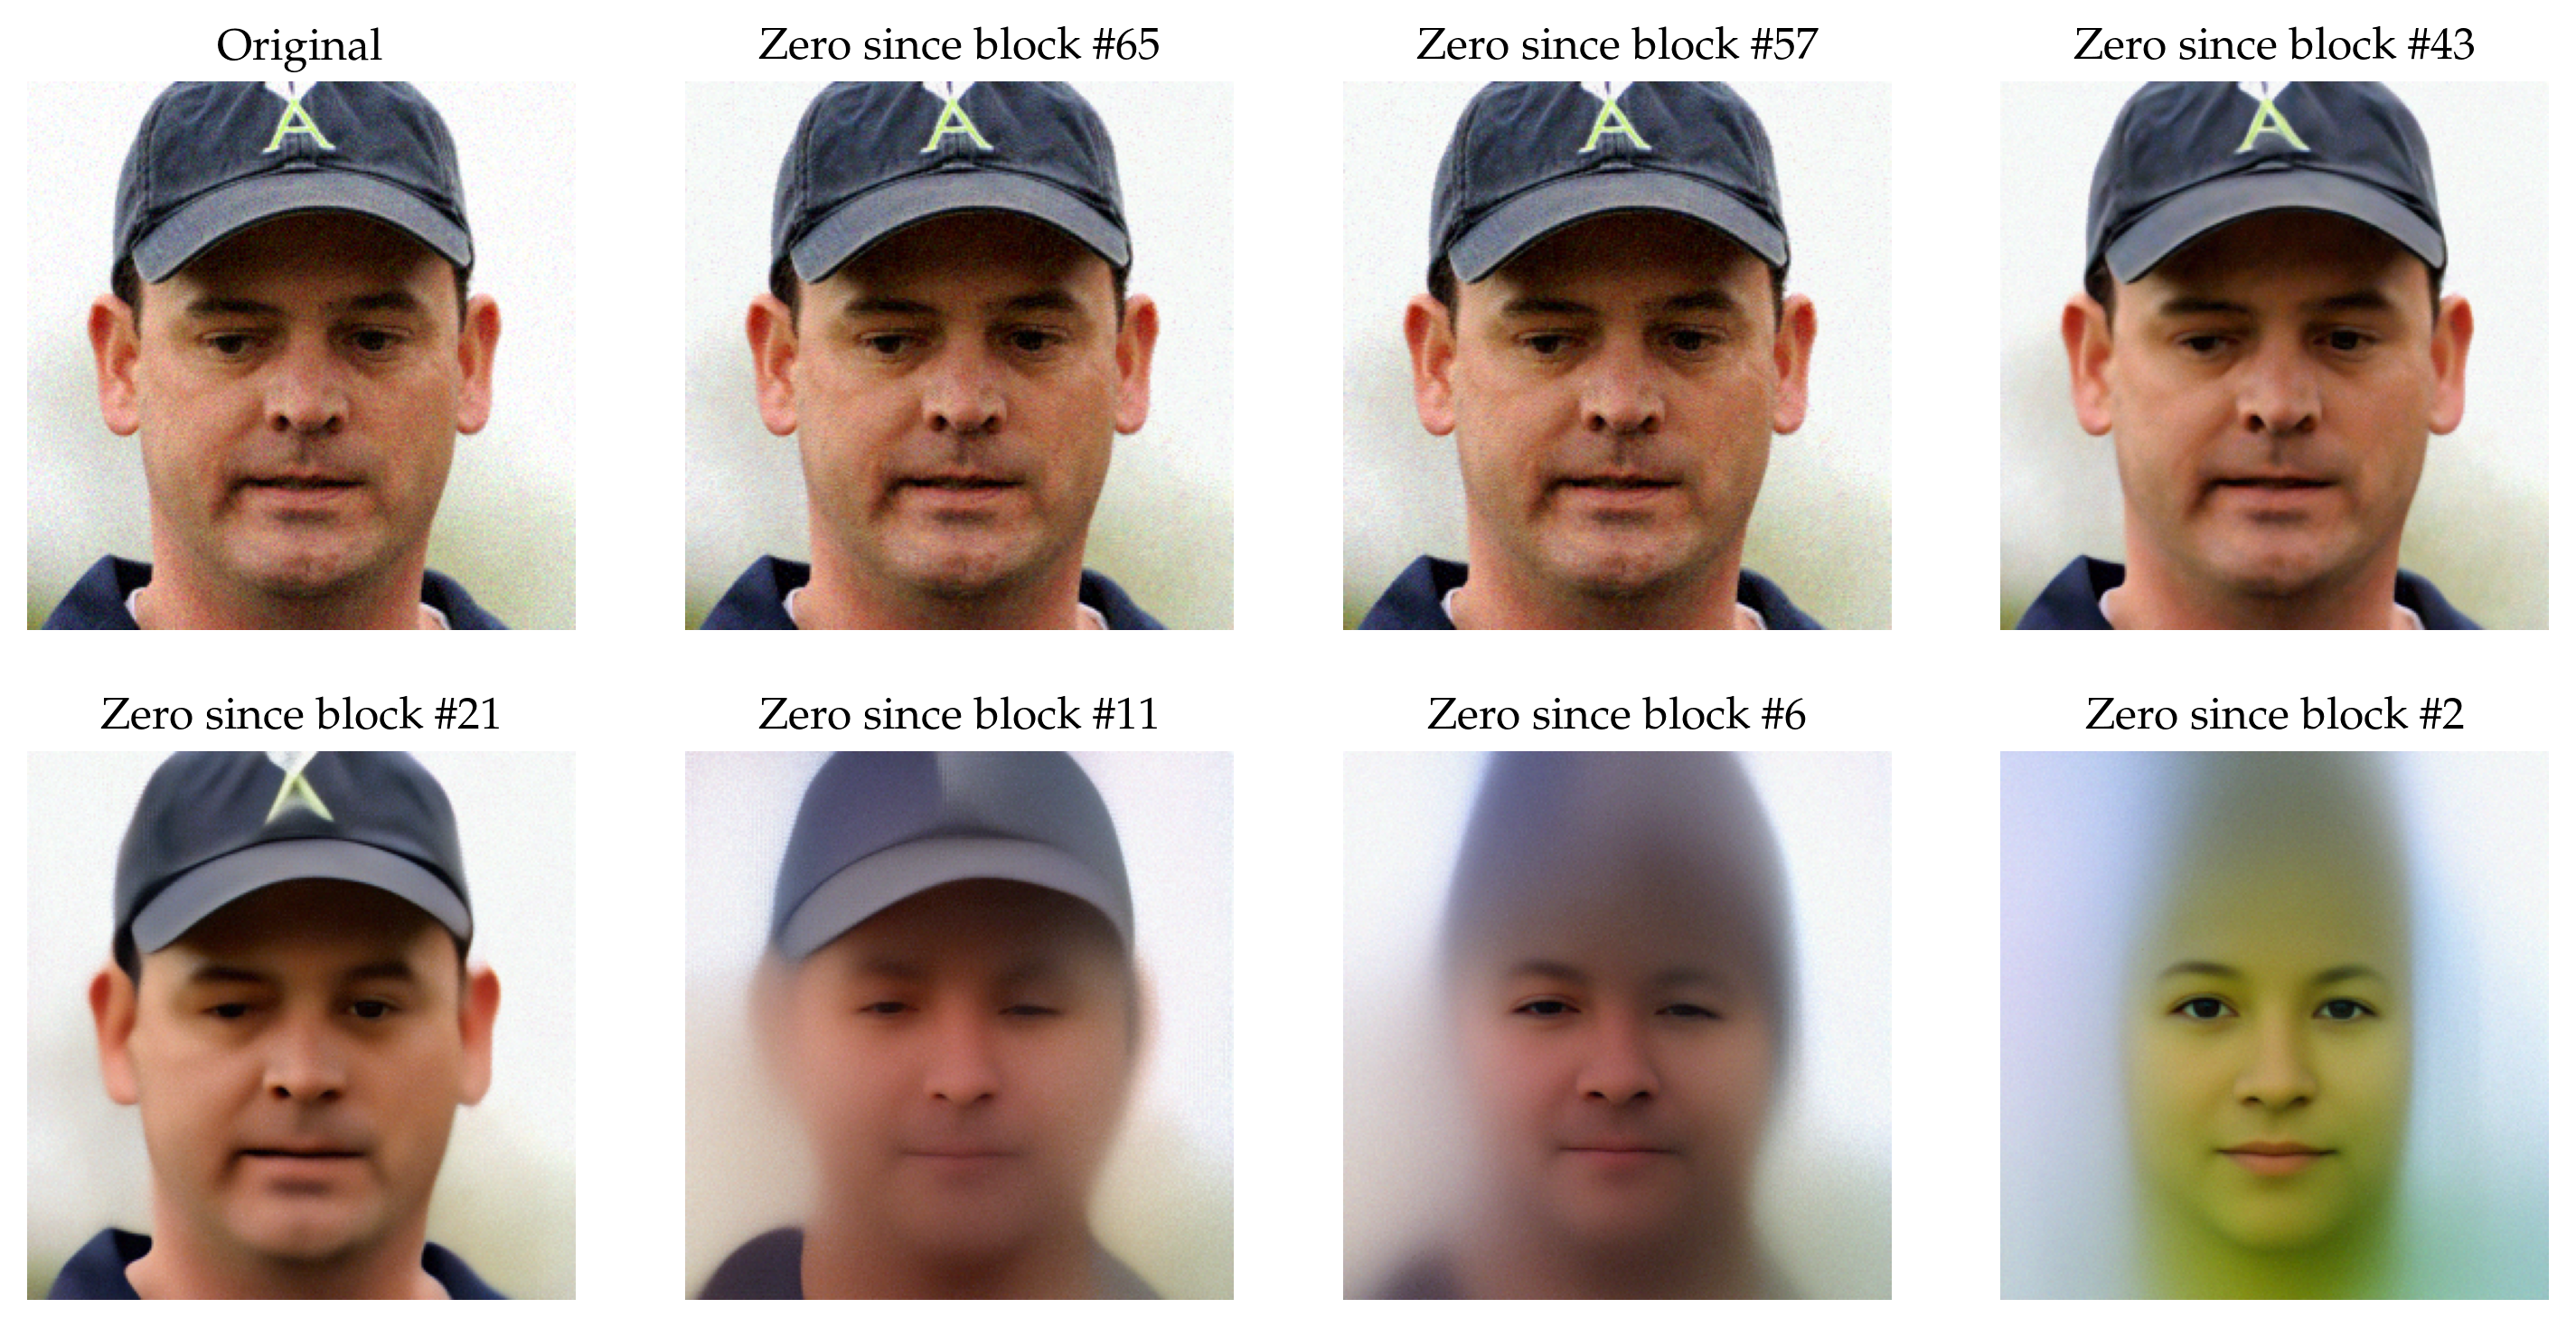

In [10]:
plt.figure(figsize=(12,6), dpi=300);

plt.subplot(2,4,1); plt.imshow(image); plt.title('Original'); plt.axis('off');
for i,a in enumerate(null):
    plt.subplot(2,4,i+2); plt.imshow(x_images[i].cpu()); plt.title('Zero since block \#%d'%a); plt.axis('off');

In [11]:
# Visualize epsilon distribution
vect = encoder(image)
print(vect.shape)
print(vect)

torch.Size([4470816])
tensor([ 4.9119,  0.8032, -1.1527,  ..., -2.1135, -0.9137, -0.4086],
       device='cuda:0')


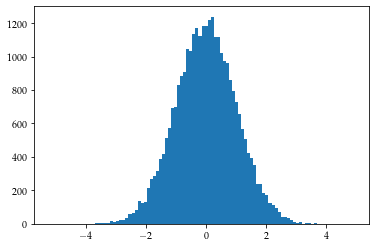

In [12]:
vals = vect[:30000].cpu().numpy()
plt.hist(vals, 100);

## Random samples (Gaussian)

In [13]:
z = encoder(image)
zdim = z.nelement()
z2 = torch.randn_like(z)

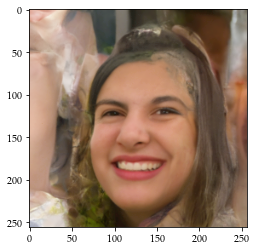

In [14]:
temp = 0.7
x2 = decoder(z2, temp)[0]
plt.imshow(x2.cpu());

## Reconstruction `decoder(encoder(x))`

In [15]:
x_input = image.to(device)
vect = encoder(x_input)
means, sigma = decoder(vect)

print('vect.shape:', vect.shape)
print('means.shape:', means.shape)
print('sigma:', sigma)

xr = means.cpu()

vect.shape: torch.Size([4470816])
means.shape: torch.Size([256, 256, 3])
sigma: 0.01


In [16]:
print(image.min(), image.max())
print(xr.min(), xr.max())

tensor(-0.1619) tensor(1.1570)
tensor(0.) tensor(1.)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


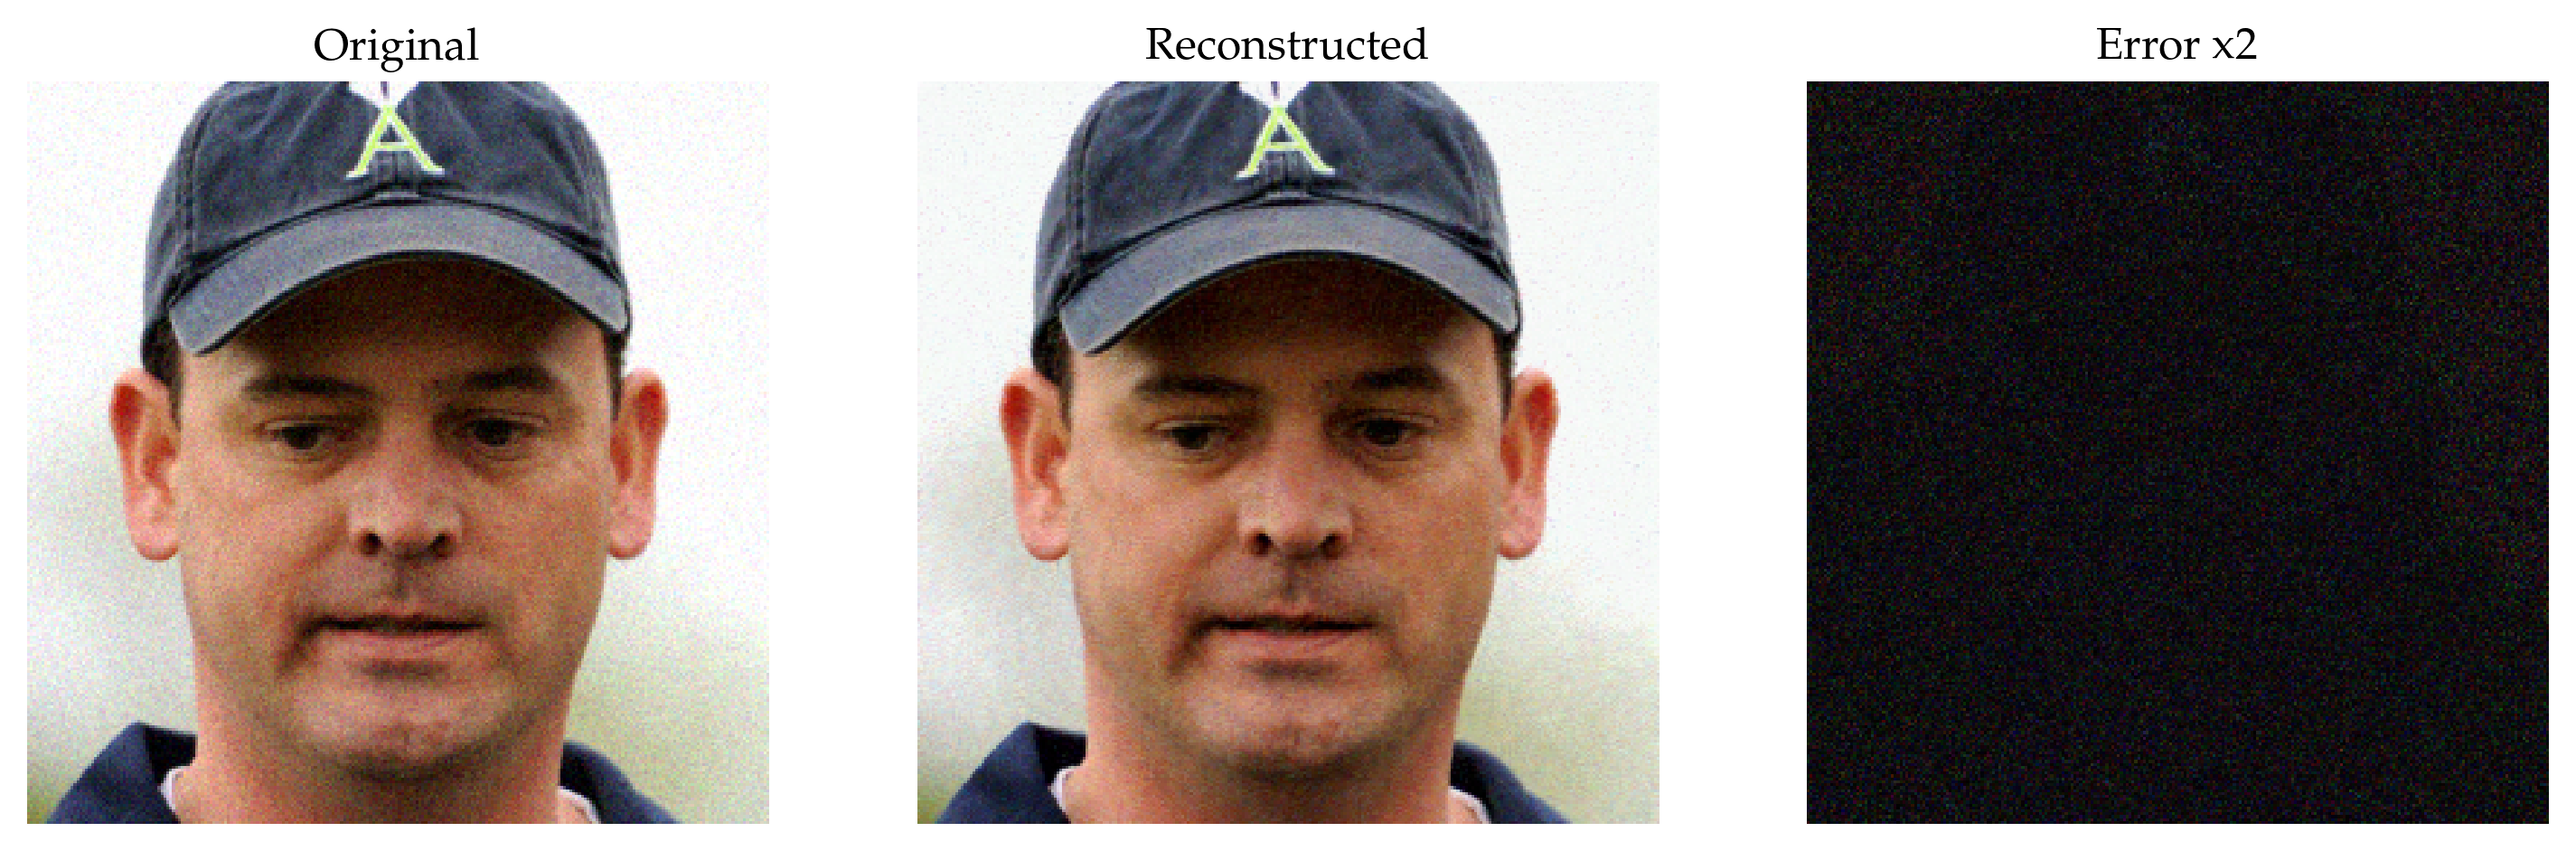

In [17]:
plt.figure(figsize=(12,6), dpi=300);

plt.subplot(1,3,1); plt.imshow(image); plt.title('Original'); plt.axis('off');
plt.subplot(1,3,2); plt.imshow(xr); plt.title('Reconstructed'); plt.axis('off');

factor = 2
plt.subplot(1,3,3); plt.imshow(factor*(torch.abs(image-xr))); plt.title('Error x%d'%factor); plt.axis('off');